# Setup

In [1]:
! pip install -q kaggle

Upload your kaggle.json file (to download your kaggle.json file follow the instructions here: https://www.kaggle.com/general/156610)

In [2]:
from google.colab import files

files.upload() # Choose your kaggle.json file

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"rio1721","key":"3065f215807361ecb99969ae3ff08343"}'}

In [3]:
# import necessary packages
import os
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import numpy as np
import pandas as pd
import csv
import random
from difflib import SequenceMatcher

Mounted at /content/gdrive


Grab kaggle data

In [4]:
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json
! kaggle competitions download -c 'march-machine-learning-mania-2023'
! mkdir march-machine-learning-mania
! unzip march-machine-learning-mania-2023.zip -d march-machine-learning-mania

 88% 25.0M/28.5M [00:01<00:00, 17.6MB/s]
100% 28.5M/28.5M [00:02<00:00, 14.7MB/s]
Archive:  march-machine-learning-mania-2023.zip
  inflating: march-machine-learning-mania/Cities.csv  
  inflating: march-machine-learning-mania/Conferences.csv  
  inflating: march-machine-learning-mania/MConferenceTourneyGames.csv  
  inflating: march-machine-learning-mania/MGameCities.csv  
  inflating: march-machine-learning-mania/MMasseyOrdinals_thru_Season2023_Day128.csv  
  inflating: march-machine-learning-mania/MNCAATourneyCompactResults.csv  
  inflating: march-machine-learning-mania/MNCAATourneyDetailedResults.csv  
  inflating: march-machine-learning-mania/MNCAATourneySeedRoundSlots.csv  
  inflating: march-machine-learning-mania/MNCAATourneySeeds.csv  
  inflating: march-machine-learning-mania/MNCAATourneySlots.csv  
  inflating: march-machine-learning-mania/MRegularSeasonCompactResults.csv  
  inflating: march-machine-learning-mania/MRegularSeasonDetailedResults.csv  
  inflating: march-mach

In [5]:
m_team_data = pd.read_csv('/content/march-machine-learning-mania/MTeams.csv')
w_team_data = pd.read_csv('/content/march-machine-learning-mania/WTeams.csv')
TEAM_DATA = m_team_data.append(w_team_data, ignore_index=True)

m_team_spellings = pd.read_csv('/content/march-machine-learning-mania/MTeamSpellings.csv', encoding='latin1')
w_team_spellings = pd.read_csv('/content/march-machine-learning-mania/WTeamSpellings.csv', encoding='latin1')
TEAM_SPELLINGS = m_team_spellings.append(w_team_spellings, ignore_index=True)

<ipython-input-5-d5d4234e36e2>:3: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  TEAM_DATA = m_team_data.append(w_team_data, ignore_index=True)
<ipython-input-5-d5d4234e36e2>:7: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  TEAM_SPELLINGS = m_team_spellings.append(w_team_spellings, ignore_index=True)


# `team` and `bracket` classes

In [6]:
class team:

  def __init__(self, ID, name, alternate_names):
    self.ID = ID
    self.name = name
    self.alternate_names = alternate_names

In [145]:
class bracket:
  
  def __init__(self, team_list, ID_data, year=2023, w=False):
    self.team_list = team_list
    self.ID_data = ID_data
    self.year = year
    self.w = w
    self.name_reference_matrix = []

    # initializes name_reference_matrix with all alternate names
    for x in self.team_list:
      for y in x.alternate_names:
        self.name_reference_matrix.append([x.name, y.lower(), x.ID])
    self.name_reference_matrix = np.array(self.name_reference_matrix)

    # initializes ID_data_dict with kaggle result data (predicted probabilities)
    self.ID_data_dict = {}
    for i in range(len(self.ID_data["ID"])):
      line = self.ID_data["ID"][i].split('_')
      pred = self.ID_data["Pred"][i]
      self.ID_data_dict[line[1] + '_' + line[2]] = float(pred)
      self.ID_data_dict[line[2] + '_' + line[1]] = float(1 - pred)


  def get_team_list(ID_data, team_data=TEAM_DATA, team_spellings=TEAM_SPELLINGS):
    # Uses ID data to get complete list of teams 
    team_list = []
    ID_list = []
    for row in ID_data["ID"]:
      team1, team2 = int(row.split('_')[1]), int(row.split('_')[2])
      for each_team in [team1, team2]:
        if each_team not in ID_list:
          name = team_data["TeamName"][np.where(team_data["TeamID"] == each_team)[0][0]]
          alternate_names = list(team_spellings["TeamNameSpelling"][np.where(team_spellings["TeamID"] == each_team)[0]])
          this_team = team(each_team, name, alternate_names)
          team_list.append(this_team)
          ID_list.append(each_team)

    return team_list
  
  def get_team_name(self, ID):
    # Gets team name from ID
    if type(ID) is int:
      i = np.where(self.name_reference_matrix[:,2] == str(ID))[0][0]
      return self.name_reference_matrix[i][0]
    elif type(ID) is list:
      return [self.get_team_name(x) for x in ID]
    else:
      return self.get_team_name(int(ID))

  def _get_team_id(self, name_list):
    # gets IDs for a list of team names

    if type(name_list) is str:
      name_list = [name_list]

    id_list = []
    for name_idx in range(len(name_list)):
      similarity_scores = [self.name_similarity(name_list[name_idx], i[1], ID=i[2]) for i in self.name_reference_matrix]
      id_list.append(self.name_reference_matrix[similarity_scores.index(max(similarity_scores))][2])

    return id_list

  def _get_winner(self, team1, team2, do_print=False):
    # Returns team with > 0.5 chance of winning to get most probable victor
    prob_team_1 = self.ID_data_dict[team1 + '_' + team2]
    if do_print:
      print(self.get_team_name(team1), self.get_team_name(team2), prob_team_1)
    if prob_team_1 >= 0.5:
      return team1
    else:
      return team2
  
  def name_similarity(self, a, b, ID=None):
    # Returns score for string similarity from 0 to 1 using SequenceMatcher

    if ID is not None: # if considering women's team while self.w is false or considering men's while self.w is true, return 0
      if ID[0] == '3' and self.w == False:
        return 0
      elif ID[0] == '1' and self.w == True:
        return 0

    a = a.lower()
    b = b.lower()
    if a < b:
      a, b = b, a
    if a == b:
      return 1
    elif a in b or b in a:
      return (1 + SequenceMatcher(None, a, b).ratio()) / 2
    else:
      return (SequenceMatcher(None, a, b).ratio()) / 2

  
  def get_bracket(self, round_of_64, do_print=False):
    # Returns list of each round's victors decided by team with higher probability of winning
    assert len(round_of_64) == 64

    if round_of_64[0].isdigit() == False:
      teams = self._get_team_id(round_of_64)
    else:
      teams = round_of_64
    
    remaining_teams = 64
    to_return = [teams[:]]
    while remaining_teams != 1:
      for i in range(int(remaining_teams / 2)):
        prob = self.ID_data_dict[teams[2 * i] + '_' + teams[2 * i + 1]]
        if prob > 0.5:
          if do_print:
            print("Team 1 wins", self.get_team_name(teams[2 * i]), self.get_team_name(teams[2 * i + 1]), prob)
          teams[i] = teams[2 * i]
        else:
          if do_print:
            print("Team 2 wins", self.get_team_name(teams[2 * i]), self.get_team_name(teams[2 * i + 1]), prob)
          teams[i] = teams[2 * i + 1]
      remaining_teams /= 2
      to_return.append(teams[:int(remaining_teams)][:])

    return to_return

  def get_a_winner(self, round_of_64, do_print=False):
    # Returns the winner of a stochastic game (with provided probability set-up)
    assert len(round_of_64) == 64

    if round_of_64[0].isdigit() == False:
      teams = self._get_team_id(round_of_64)
    else:
      teams = round_of_64
    
    remaining_teams = 64
    while remaining_teams != 1:
      for i in range(int(remaining_teams / 2)):
        prob = self.ID_data_dict[teams[2 * i] + '_' + teams[2 * i + 1]]
        if random.random() < prob:
          if do_print:
            print("Team 1 wins", self.get_team_name(teams[2 * i]), self.get_team_name(teams[2 * i + 1]), prob)
          teams[i] = teams[2 * i]
        else:
          if do_print:
            print("Team 2 wins", self.get_team_name(teams[2 * i]), self.get_team_name(teams[2 * i + 1]), prob)
          teams[i] = teams[2 * i + 1]
      
      remaining_teams /= 2
    
    return teams[0]
  
  def run_monte_carlo(self, round_of_64, iterations=10, do_print=False):
    # Repeatedly calls get_a_winner
    results = []
    for x in range(iterations):
      results.append(self.get_a_winner(round_of_64, do_print=do_print))
    
    return [self.get_team_name(i) for i in results]

  def power_score(self, team, round_of_64):
    # Computes average of probabilities of beating each other team
    assert len(round_of_64) == 64
    i = round_of_64.index(team)

    if round_of_64[0].isdigit() == False:
      round_of_64 = self._get_team_id(round_of_64)

    team = round_of_64[i]

    return np.mean(np.array([self.ID_data_dict[team + '_' + round_of_64[x]] for x in range(len(round_of_64)) if team != round_of_64[x]]))


  def plot_bracket(self, rounds, size=(15,6), tight_layout=False):
    num_rounds = len(rounds)
    num_teams = len(rounds[0])
    multiplier = 0.6

    fig, ax = plt.subplots(figsize=size)
    ax.set_xlim([0, num_rounds + 1])
    ax.set_ylim([0, num_teams / 2])

    # Calculate column height and spacing
    column_height = num_teams / (2 ** (num_rounds - 1))

    prev_ys = []
    new_prev_ys = []

    # Plotting the team names
    for r, round_teams in enumerate(rounds):
      round_size = len(round_teams)
      round_height = column_height * round_size

      for t, team_name in enumerate(round_teams):
        if t < round_size // 2:  # First half of teams
          x = r * multiplier
          if len(prev_ys) == 0:
            y = (column_height * (2 * t + 1)) - round_height / 2
          else:
            y = (prev_ys[2 * t] + prev_ys[2 * t + 1]) / 2
          new_prev_ys.append(y)
        else:  # Second half of teams
          x = num_rounds - (r * multiplier)
          if len(prev_ys) == 0:
            y = (column_height * (2 * (t - round_size // 2) + 1)) - round_height / 2
          else:
            y = (prev_ys[2 * t] + prev_ys[2 * t + 1]) / 2
          new_prev_ys.append(y)

        if r == num_rounds - 1:
          x = num_rounds / 2

        if team_name == rounds[-1][0]:
          ax.text(x, y, team_name, ha='center', va='center', fontsize=8, bbox=dict(facecolor='none', edgecolor='green'))
        else:
          ax.text(x, y, team_name, ha='center', va='center', fontsize=8)
      prev_ys = new_prev_ys
      new_prev_ys = []
      
    ax.invert_yaxis()
    ax.axis('off')
    if tight_layout:
      plt.tight_layout()
    plt.show()


# Example

In [146]:
kaggle_data = pd.read_csv('<PATH TO KAGGLE SUBMISSION FILE')

In [147]:
team_list = bracket.get_team_list(kaggle_data)

In [148]:
bracket_2023 = [
  'Alabama',
  'Texas A&M',
  'Maryland',
  'West Virginia',
  'San Diego St.',
  'Charleston',
  'Virginia',
  'Furman',
  'Creighton',
  'NC State',
  'Baylor',
  'UC Santa Barbara',
  'Missouri',
  'Utah State',
  'Arizona',
  'Princeton',
  'Purdue',
  'Fairleigh Dickinson',
  'Memphis',
  'Florida Atlantic',
  'Duke',
  'Oral Roberts',
  'Tennessee',
  'Louisiana',
  'Kentucky',
  'Providence',
  'Kansas State',
  'Montana State',
  'Michigan State',
  'USC',
  'Marquette',
  'Vermont',
  'Houston',
  'Northern Kentucky',
  'Iowa',
  'Auburn',
  'Miami',
  'Drake',
  'Indiana',
  'Kent State',
  'Iowa State',
  'Pittsburgh',
  'Xavier',
  'Kennesaw State',
  'Texas A&M',
  'Penn State',
  'Texas',
  'Colgate',
  'Kansas',
  'Howard',
  'Arkansas',
  'Illinois',
  'Saint Mary\’s',
  'VCU',
  'UConn',
  'Iona',
  'TCU',
  'Nevada',
  'Gonzaga',
  'Grand Canyon',
  'Northwestern',
  'Boise State',
  'UCLA',
  'UNC Asheville'
]

Round of 64: ['Alabama', 'Texas A&M', 'Maryland', 'West Virginia', 'San Diego St', 'Col Charleston', 'Virginia', 'Furman', 'Creighton', 'NC State', 'Baylor', 'UC Santa Barbara', 'Missouri', 'Utah St', 'Arizona', 'Princeton', 'Purdue', 'F Dickinson', 'Memphis', 'FL Atlantic', 'Duke', 'Oral Roberts', 'Tennessee', 'Louisiana', 'Kentucky', 'Providence', 'Kansas St', 'Montana St', 'Michigan St', 'USC', 'Marquette', 'Vermont', 'Houston', 'N Kentucky', 'Iowa', 'Auburn', 'Miami FL', 'Drake', 'Indiana', 'Kent', 'Iowa St', 'Pittsburgh', 'Xavier', 'Kennesaw', 'Texas A&M', 'Penn St', 'Texas', 'Colgate', 'Kansas', 'Howard', 'Arkansas', 'Illinois', "St Mary's CA", 'VCU', 'Connecticut', 'Iona', 'TCU', 'Nevada', 'Gonzaga', 'Grand Canyon', 'Northwestern', 'Boise St', 'UCLA', 'UNC Asheville']
Round of 32: ['Alabama', 'Maryland', 'San Diego St', 'Virginia', 'NC State', 'UC Santa Barbara', 'Missouri', 'Arizona', 'Purdue', 'FL Atlantic', 'Duke', 'Tennessee', 'Kentucky', 'Kansas St', 'Michigan St', 'Marquet

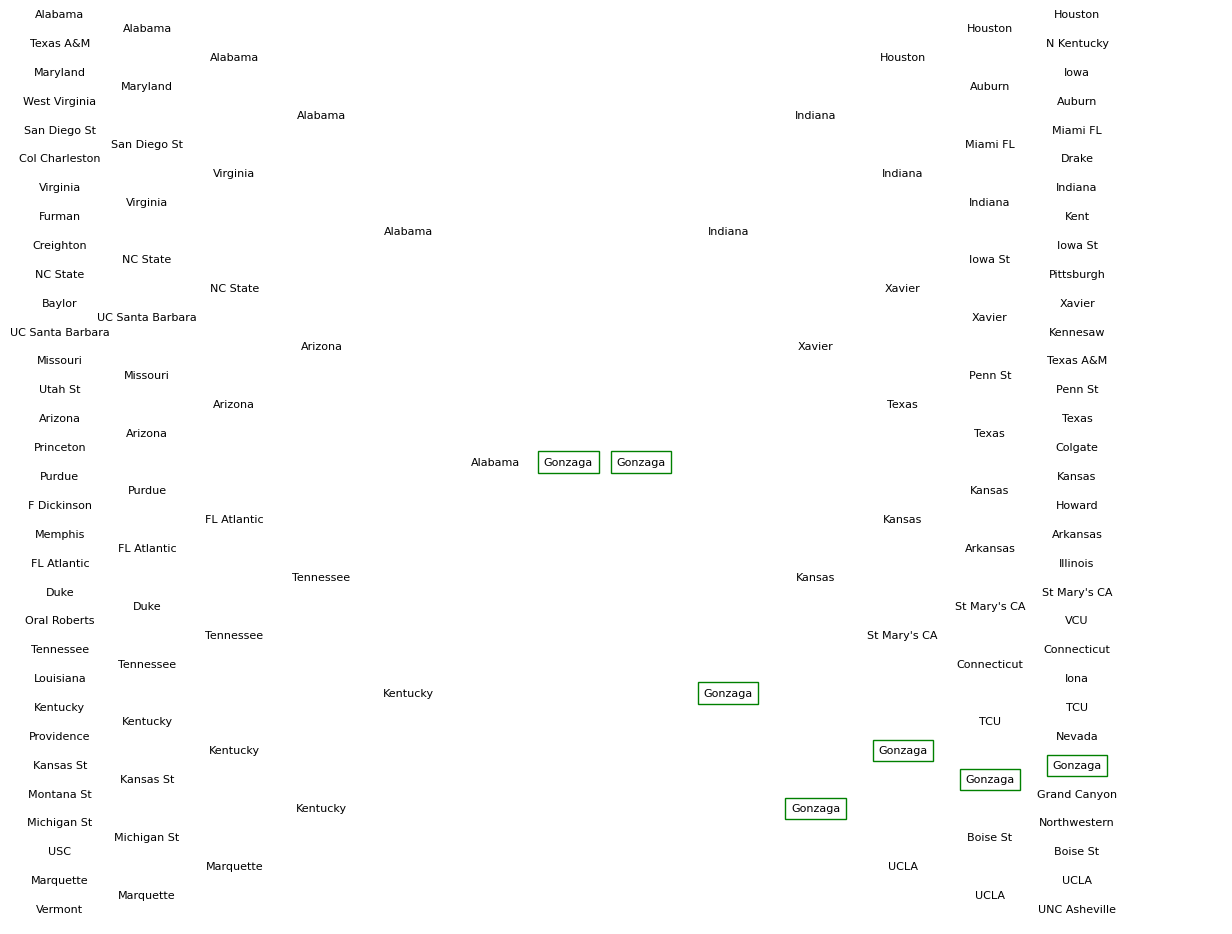

In [150]:
cavia = bracket(team_list, kaggle_data, w=False)
results = cavia.get_bracket(bracket_2023)
result_names = cavia.get_team_name(results)

for result in result_names:
  print(f"Round of {len(result)}: {result}")

cavia.plot_bracket(result_names)

In [87]:
cavia.run_monte_carlo(bracket_2023, iterations=5)

['Purdue', 'USC', 'Texas', 'Creighton', 'Gonzaga']